# Assignment 1 - class scheduling

## Initialization

In [33]:
import matplotlib.pyplot as plt

class Timeslot():
    def __init__(self, start, end, color, title):
        self.start = start
        self.end = end
        self.color = color
        self.title = title

def applyTimeslots(offset, limit, timeslots, ax):
    for timeslot in timeslots:
        ax.fill_between([offset + 0.05, limit - 0.05], [timeslot.start + 0.05, timeslot.start + 0.05], [timeslot.end - 0.05,timeslot.end - 0.05], color=timeslot.color, edgecolor='k', linewidth=0.5, alpha=0.4
                        )
        ax.text(float(limit - offset) / 2 + offset, (timeslot.start + timeslot.end) / 2, timeslot.title, ha="center", va="center", fontsize=12)
        
def plotDay(timeslots):
    width = 10
    height = 8
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    ax.set_ylabel("Time")
    ax.axes.get_xaxis().set_visible(False)
    fig.gca().invert_yaxis()

    applyTimeslots(margin, width - margin, timeslots, ax)
    
    ax.set_title("Day")
    
    plt.show()
    
def plotWeek(timeslotDays, dayStartAndEnd = None):
    width = 15
    height = 8
    weekdays = 7
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    
    if dayStartAndEnd != None:
        (start, end) = dayStartAndEnd
        
        plt.yticks(range(start, end + 1))
        fig.gca().set_ylim([start,end])
    
    ax.set_ylabel("Time")
    #ax.axes.get_xaxis().set_visible(False)
    
    fig.gca().invert_yaxis()
    
    dayWidth = width / weekdays
    
    def genDays(): 
        days = ["Monday", "Tuesday", "Wensday", "Thursday", "Friday", "Saturday", "Sunday"]
        
        
        fig.gca().set_xlim([0,len(days)])
        

        for i, day in enumerate(days):
            yield (day, i * dayWidth + (dayWidth / 2))
            
    tickedDays = list(genDays())
    
    plt.xticks(list(map(lambda x: x[1], tickedDays)), list(map(lambda x: x[0], tickedDays)))
    
    for i, dayTimeslots in enumerate(timeslotDays):
        offset = i * dayWidth
        
        applyTimeslots(offset, offset + dayWidth, dayTimeslots, ax)

    
    ax.set_title("Week")
    
    plt.show()
    
    

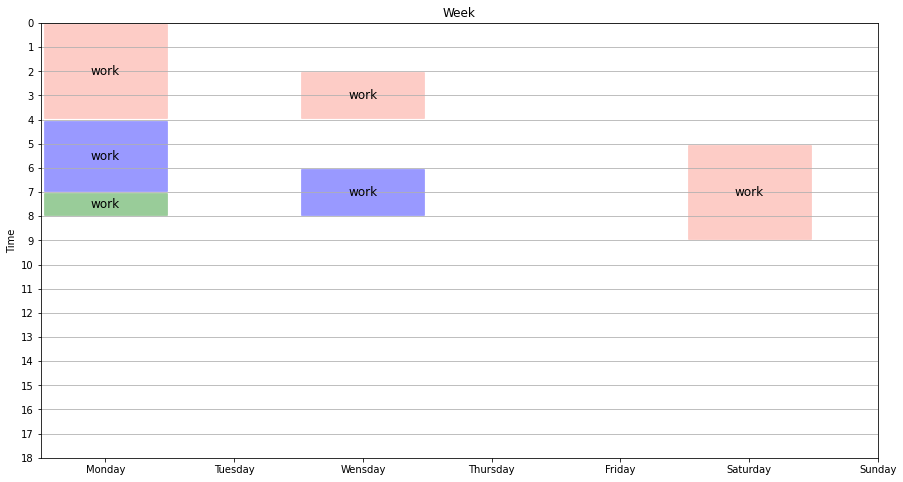

In [2]:
slots1 = [Timeslot(0, 4, "salmon", "work"), Timeslot(4, 7, "Blue", "work"), Timeslot(7, 8, "Green", "work")]
slots2 = []
slots3 = [Timeslot(2, 4, "salmon", "work"), Timeslot(6, 8, "Blue", "work")]
slots4 = []
slots5 = []
slots6 = [Timeslot(5, 9, "salmon", "work")]
slots7 = []

plotWeek([slots1, slots2, slots3, slots4, slots5, slots6, slots7], (0, 18))

## Model

## Initial description

We have:
* $P = (h,d,w)| h \in \text{Hours, } d \in \text{Days, } w \in \text{Weeks}$ 
* Rooms $R$
* Classes $E$ with duration $\ell(e), e \in E$
* Presedence digraph $D = (E, A)\text{, } uv \in A \text{ for } u, v \in E$
* Students $S$ and teachers $T$ with:
    * Enrollments $Q = E_s \subset E | s \in S$
    * Teaching duties $D = D_t \subset E | t \in T$
    * Unavailabilites $\mathcal{U} = U_t \subset P | t \in T$
    
Additionally I will use $B_r$ as the collection of busy times for a given room, eg $B = \{ B_r \subset P \,|\, r \in R \}$

## Model interpretation

### Hard constraints

All classes should be allocated in their designated weeks.
$$x_{erp} \in \{0, 1\}$$
$$\sum_{(h,d,w) \in P, r \in R} x_{e,r,(h,d,week(e))} = 1, \forall e \in E$$

Classes should never overlap and range their full duration.
$$\sum_{e \in E} \, \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall r \in R$$

A teacher may not teach two classes at the same time, no more than one room may ever be occupied by a class that requires the same teacher within the entire timeframe of a lecture.
$$\sum_{e \in d_e} \, \sum_{r \in R} \, \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall d_e\in D$$

A room should never be occupied during a busy period.
$$\sum^h_{i=max(0, h - \ell(e) + 1)}  x_{e,r,(i,d,w)} = 0 ,\, \forall (h,d,w) \in B_r ,\, \forall e \in E ,\, \forall r \in R$$

The presedence graph should be followed, basically we get the "activation" day, if the class is allocated in day $3$ its binary value will be $1$, thus the allocated day will be $1*3$.
The difference between the in-arc vertex's day in $e_1$ and the current day in $e_2$ must be at least $1$ (in favor of the preceding vertex being larger).
The complexity of this constraint is actually quite small, since all the relevant $p \in P$ are only the ones containing $w = week(e_2) , \, (h,d,w) \in P$
$$\sum_{r \in R} \, \sum_{(h,d,w) \in P} x_{e_2,r,(h,d,week(e_2)} * d - \sum_{r \in R} \, \sum_{(h,d,w) \in P} x_{e_1,r,(h,d,week(e_1)} * d \geq 1, \, \forall e_1e_2 \in A, \, \forall e_2 \in E$$

For each course, there may only be one event per day for each student.
$$\sum_{r \in R} \sum_{e \in SE} \sum_{h' \in H_{d,w}} x_{e,r,(h',d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall SE \in U$$

We should of course also handle the case that the events do not exceed the day (eg a lecture of duration 2 may never begin at $final_{d,w} - \ell(e) + 1$, final being the final hour slot of the day.
$$ \sum_{(d,w) \in P} x_{e,r,(h,d,w)}, \, \forall e \in E , \, \forall r \in R$$

### Soft constraints

The soft constraints are where the quality of the model is gained.

Discomfort is minimized in regard to bad slots.
We let $O$ be the set of $c_p$ where $p \in P$ and $c \in \mathbb{N}$, $c$ being an arbitrary weight of how "bad" a timeslot is.
$$\alpha = \sum_{(h,d,w) \in P} \, \sum_{e \in E} \, \sum_{r \in R} \, \left( \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \right) * c_{h,d,w}$$

The number of events per day for a teacher is minimized, it should be noted that $(d,w) \in P$ are all **distinct** $(d,w)$ pairs.
We find the maximum lectures $ml$ of any one day for any one teacher, this should be minimized. An average case minimization is harder to formulate.
$$ml >= \sum_{e \in d_e} \, \sum_{h' \in H_{d,w}} \, \sum_{r \in R} x_{e,r,(h',d,w)}, \, \forall (d,w) \in P, \, \forall d_e \in D$$

The number of events per day for a teacher is minimized, it should be noted that $(d,w) \in P$ are all **distinct** $(d,w)$ pairs.
$$y = \frac{\sum_{d_e \in D} \, \sum_{(d,w) \in P} \, min \left(0, \left( \sum_{e \in d_e} \sum_{r \in R} \sum_{h' \in H_{d,w}} x_{e,r,(h',d,w)} \right)^2 - 1 \right)}{|D|}$$

Here I sum up all events for a teacher for a given day in all rooms. I square the result to enforce a large growth, diving by the amount of teachers for normalization in respect to the range.

## Code

### Initilization

In [3]:
import pyomo.environ as po
import src.data as imp
import time

dataImporter = imp.Data("data/small")

slots = dataImporter.slots
banned = dataImporter.banned
events = dataImporter.events
teachers = dataImporter.teachers
students = dataImporter.students
rooms = dataImporter.rooms

In [62]:
class ModelDataMapping:
    def __init__(self, E, P, R, D, T, B, S, U, O, namedEvents, indexedRooms, teacherPairs, courseIdToTeacherMapping, eventLookup, eventIdToCourseId, dayWeekMaxHrPairs):
        self.E = E
        self.P = P
        self.R = R
        self.D = D
        self.T = T
        self.B = B
        self.S = S
        self.U = U
        self.O = O
        self.namedEvents = namedEvents
        self.indexedRooms = indexedRooms
        self.teacherPairs = teacherPairs
        self.courseIdToTeacherMapping = courseIdToTeacherMapping
        self.eventLookup = eventLookup
        self.eventIdToCourseId = eventIdToCourseId
        self.dayWeekMaxHrPairs = dayWeekMaxHrPairs

def prepareModel(events, students, teachers, slots, banned, rooms):
    print("Preparing data")
    rooms_as_list = list(rooms.items())
    
    R = list(range(len(rooms_as_list)))
    namedEvents = [(eventSet, e) for eventSet in events for e in events[eventSet]]
    E = list(range(len(namedEvents)))
    P = [(s["hour"], s["day"], s["week"]) for s in slots]
    preparedBanned = [(b["hour"], b["day"], b["week"]) for b in banned]
    
    eventIdToIndex = dict([(e[1]["id"], i) for i, e in enumerate(namedEvents)])
    teacherPairs = list(teachers.items())
    T = range(len(teacherPairs))

    def indexedTeacherEvents():
        for teacherId, eventsForTeacher in teacherPairs:
            onlyEvents = [e["events"] for e in eventsForTeacher]

            flattenedEvents = [eventIdToIndex[b] for a in onlyEvents for b in a]

            yield flattenedEvents
    
    D = list(indexedTeacherEvents())
    
    studentPairs = list(students.items())
    S = range(len(studentPairs))
    
    def indexedStudentEvents():
        for studentId, eventsForStudent in studentPairs:
            onlyEvents = [e["events"] for e in eventsForStudent]

            flattenedEvents = [eventIdToIndex[b] for a in onlyEvents for b in a]

            yield flattenedEvents
            
    U = list(indexedStudentEvents())
    
    def busyRoomsForTime():
        # For O(1) lookup
        PAsSet = set(P)
        
        def formatEvent(e):
            return (e["hour"], e["day"], e["week"])

        for roomIndex, r in enumerate(rooms_as_list):
            (k, v) = r

            formattedBusyEvents = list(map(lambda e: formatEvent(e), v["busy"]))
            
            # filter out all events that do not exist in the timeslots data-set
            def removeInvalidTimes():
                for p in formattedBusyEvents:
                    if p in PAsSet:
                        yield p
            
            yield (roomIndex, list(removeInvalidTimes()))

    B = dict(busyRoomsForTime())
    
    # courseId to teacher mapping
    courseIdToTeacherMapping = [ [] for i in range(len(E)) ]

    for teacherIdx, d in enumerate(D):
        for e in d:
            courseIdToTeacherMapping[e].append(teacherIdx)
            
    def eventLookup():
        for i, (k, v) in enumerate(namedEvents):
            yield (v["id"], i)
            
    def eventIdToCourseId():
        for courseId, event in namedEvents:
            yield (event["id"], courseId)
            
    def dayWeekMaxHrPairs():
        def genDWHPairs():
            for (h,d,w) in P:
                yield ((d,w), h)
        
        dwh = list(genDWHPairs())
        
        for k in dict(dwh):
            yield (k, max(map(lambda x: x[1], filter(lambda x: x[0] == k, dwh))))
            
    EidtoCid = dict(list(eventIdToCourseId()))
    
    elook = dict(list(eventLookup()))
    
    dwmhrp = dict(dayWeekMaxHrPairs())
            
    def orderStudentClassesIntoCourses():
        for u in U:
            # Get course type
            courseIdMap = {}
            
            for e in u:
                courseId = namedEvents[e][0]
                courseIdMap.setdefault(courseId,[]).append(e)
                
            yield courseIdMap
            
    U = list(orderStudentClassesIntoCourses())
    
    def genO():
        for ((d,w), maxHr) in dwmhrp.items():
            # lectures in hr 8 for all is rating 4 bad
            # lectuers in hr 16 for mon, tues, wed, thur is rating 2 bad
            # lectures in hr 17 for -||- is rating 3 bad
            # lectures in hr 15, 16 and 17 for fri is rating 5 bad
            def fillNs(start, end, n = 0):
                return list(map(lambda h: ((h,d,w), n), range(start, end + 1)))
            
            offset = 8
            
            if d in list(range(0, 4)):
                out = [((8 - offset,d,w), 4)] + fillNs(9 - offset,15 - offset) + [((16 - offset,d,w), 2), ((17 - offset,d,w), 3)] + fillNs(18 - offset,maxHr, 10)
            else:
                out = [((8 - offset,d,w), 4)] + fillNs(9 - offset,14 - offset) + [((15 - offset,d,w), 5), ((16 - offset,d,w), 5), ((17 - offset,d,w), 5)]  + fillNs(18 - offset,maxHr, 10)
                
            for o in out:
                yield o
                
    O = dict(list(genO()))
            
    return ModelDataMapping(E, P, R, D, T, B, S, U, O, namedEvents, rooms_as_list, teacherPairs, courseIdToTeacherMapping, elook, EidtoCid, dwmhrp)
        

In [66]:
def solveModel(preparedData):
    E = preparedData.E
    P = preparedData.P
    R = preparedData.R
    D = preparedData.D
    T = preparedData.T
    B = preparedData.B
    S = preparedData.S
    U = preparedData.U
    O = preparedData.O
    
    def duration(eventIndex):
        return preparedData.namedEvents[eventIndex][1]["duration"]
    
    print("Generating 5d/3d matrix of size", len(E) * len(R) * len(P))
    domain = [(e, r, p[0], p[1], p[2]) for e in E for r in R for p in P]
    
    m = po.ConcreteModel("timetable")
    
    print("Adding variable x")
    m.x = po.Var(domain, bounds = (0, 1), within=po.Binary)
    
    print("Adding soft constraints")
    
    print("Adding alpha")
    alpha = sum(
        sum(
            sum(
                sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) * O[(h,d,w)]
            for r in R)
        for e in E)
    for (h,d,w) in P)
                
    
    m.value = po.Objective(expr=alpha, sense=po.minimize)
    
    print("Adding hard constriants")
    
    m.scheduled = po.ConstraintList()
    
    print("Adding scheduled constraint")
    
    def weekFor(e):
        return preparedData.namedEvents[e][1]["week"]
    
    for e in E:
        weekForE = weekFor(e)
        relevantPs = list(filter(lambda p: p[2] == weekForE, P))
        irellevantPs = list(filter(lambda p: p[2] != weekForE, P))
        
        m.scheduled.add(expr = sum(m.x[(e,r,h,d,w)] for (h,d,w) in relevantPs for r in R) == 1)
        m.scheduled.add(expr = sum(m.x[(e,r,h,d,w)] for (h,d,w) in irellevantPs for r in R) == 0)
    
    m.one_event_per_student_day = po.ConstraintList()
    
    print("Adding one event per course per day per student")
    for u in U:
        for courseId, SE in u.items():
             for ((d,w), maxHr) in preparedData.dayWeekMaxHrPairs.items():
                rangeToMaxHr = range(0, maxHr + 1)

                m.one_event_per_student_day.add(sum(sum(sum(m.x[e,r,h,d,w] for h in rangeToMaxHr) for e in SE) for r in R) <= 1)
                    
            
    
    m.presedence = po.ConstraintList()
    
    def getActivationDay(e, relevantPs):
        return sum(sum(m.x[e,r,h,d,w] * d for (h, d, w) in relevantPs) for r in R)
    
    print("Adding presedence graph")
    for e2 in E:
        in_arcs = preparedData.namedEvents[e2][1]["in_arcs"]
        weekForE = weekFor(e2)
        relevantPs = list(filter(lambda p: p[2] == weekForE, P))
        
        for arcSourceId in in_arcs:
            e1 = preparedData.eventLookup[arcSourceId]
            
            m.presedence.add(getActivationDay(e2, relevantPs) - getActivationDay(e1, relevantPs) >= 1)
    
    m.no_teach_busy = po.ConstraintList()
    
    print("Adding no classes in busy period constraint")
    for r in R:
        print("Adding for room", r)
        for e in E:
            for (h,d,w) in B[r]:
                m.no_teach_busy.add(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) == 0)
        
    
    m.only_teach_one_class = po.ConstraintList()
    
    print("Adding teacher only teaches one class at a time constriants")
    for teacherIdx, de in enumerate(D):
        print("Adding for teacher", teacherIdx)
        for p in P:
            (h, d, w) = p

            m.only_teach_one_class.add(sum(sum(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) for r in R) for e in de) <= 1)
    
    m.overlap = po.ConstraintList()
    
    print("Adding overlap constriants")
    for r in R:
        print("Adding for room", r)
        for p in P:
            (h, d, w) = p

            m.overlap.add(sum(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) for e in E) <= 1)
    
            
    print("Solving...")    
        
    now = time.time()
        
    res = po.SolverFactory("gurobi").solve(m, tee=(False))
    
    later = time.time()
    difference = int(later - now)
    
    print("Done in", difference, "seconds")
            
    return m, res
            
    

In [67]:
modelDataMapping = prepareModel(events, students, teachers, slots, banned, rooms)
#for k, v in modelDataMapping.B.items():
#    l = list(filter(lambda x: x[0] > 11, v))
#    if len(l) != 0:
#        print(l)

#print(modelDataMapping.O[(11,0,6)])

#for e1 in modelDataMapping.E:
#    in_arcs = modelDataMapping.namedEvents[e1][1]["in_arcs"]
#    week1 = modelDataMapping.namedEvents[e1][1]["week"]

#    for arcSourceId in in_arcs:
#        e2 = modelDataMapping.eventLookup[arcSourceId]
#        week2 = modelDataMapping.namedEvents[e2][1]["week"]
        
#        if week1 == week2:
#            print(e1, e2)

model, result = solveModel(modelDataMapping)

Preparing data
Generating 5d/3d matrix of size 2419200
Adding variable x
Adding soft constraints
Adding alpha
Adding hard constriants
Adding scheduled constraint
Adding one event per course per day per student
Adding presedence graph
Adding no classes in busy period constraint
Adding for room 0
Adding for room 1
Adding for room 2
Adding for room 3
Adding for room 4
Adding for room 5
Adding for room 6
Adding for room 7
Adding for room 8
Adding for room 9
Adding for room 10
Adding for room 11
Adding for room 12
Adding for room 13
Adding teacher only teaches one class at a time constriants
Adding for teacher 0
Adding for teacher 1
Adding for teacher 2
Adding for teacher 3
Adding for teacher 4
Adding for teacher 5
Adding for teacher 6
Adding for teacher 7
Adding overlap constriants
Adding for room 0
Adding for room 1
Adding for room 2
Adding for room 3
Adding for room 4
Adding for room 5
Adding for room 6
Adding for room 7
Adding for room 8
Adding for room 9
Adding for room 10
Adding for r

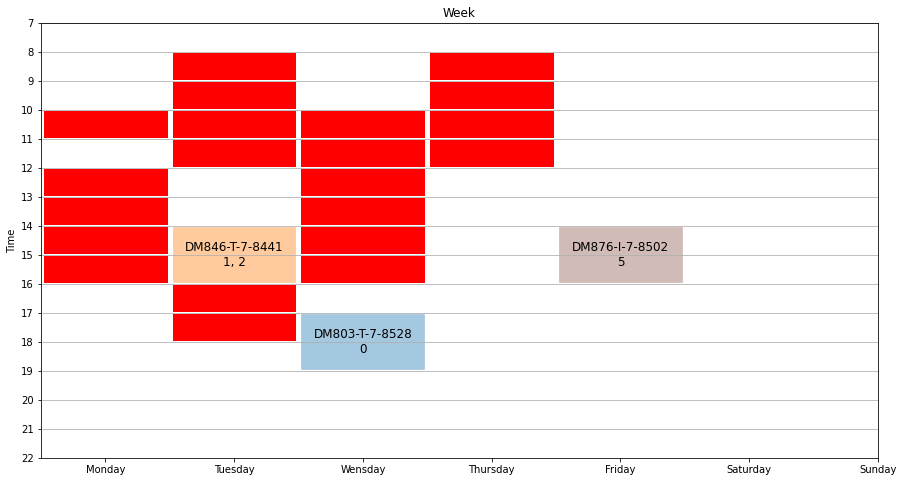

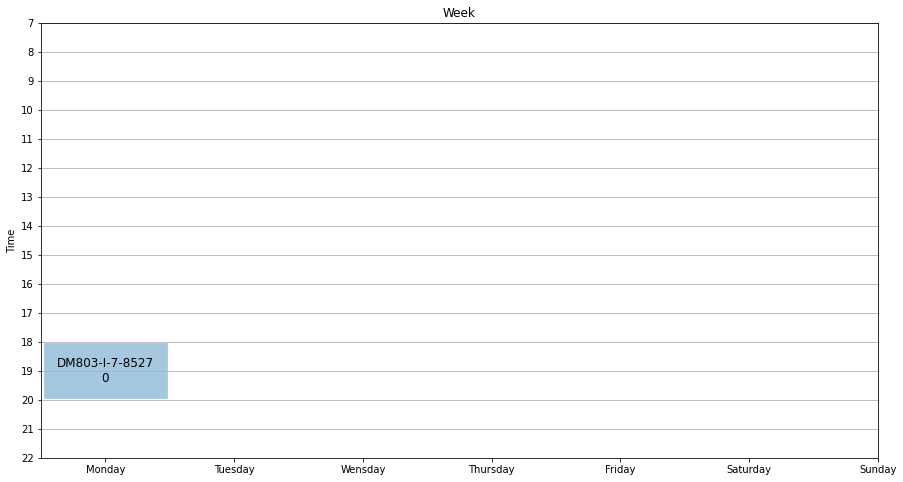

In [142]:
import matplotlib.colors as mcolors

color_map = {}

colorsAsList = list(mcolors.TABLEAU_COLORS.items())

for i, k in enumerate(events):
    color_map[k] = colorsAsList[i]
    
dayStart = 8
    
def plotFor(week, room):
    timeslots = [ [] for i in range(7) ]

    # plot data
    for e in modelDataMapping.E:
        for r in modelDataMapping.R:
            if r != room:
                continue

            for (h, d, w) in modelDataMapping.P:
                if w != week:
                    continue
                    
                s = set(modelDataMapping.B[r])
                
                namedEvent = modelDataMapping.namedEvents[e]
                
                if (h, d, w) in s:
                    timeslots[d].append(Timeslot(h + dayStart, h + dayStart + 1, "red", ""))
                    continue

                value = po.value(model.x[e,r,h,d,w])

                if value != 0:
                    color = color_map[namedEvent[0]]

                    teachersThatCanTeachThis = [str(teacherIdx) for teacherIdx in modelDataMapping.courseIdToTeacherMapping[e]]

                    timeslots[d].append(Timeslot(h + dayStart, h + dayStart + namedEvent[1]["duration"], color, namedEvent[1]["id"] + "\n" + ", ".join(teachersThatCanTeachThis)))

    plotWeek(timeslots, (7, 22))


for e in [3,2]:#modelDataMapping.E[:10]:
    for r in modelDataMapping.R:
        for p in modelDataMapping.P:
            if po.value(model.x[e,r,p]) == 1:
                #print(e,r,p)
                plotFor(week=p[2],room=r)
    
    
#plotFor(week=6, room=4)

## 